In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

"For the first model we will easily use dialect column to predict the output
for the second model we will need one hot encoding to bew a ble to train multi_label model"

In [61]:
df=pd.read_csv("transformed.csv", converters={'fineText': str})
df.head()
del df['transformed']
X=df['dialect'] 
df = pd.get_dummies(df, columns = ['dialect'])
df['dialect']=X
df.head()

,id,fineText,dialect_AE,dialect_BH,dialect_DZ,dialect_EG,dialect_IQ,dialect_JO,dialect_KW,dialect_LB,...,dialect_MA,dialect_OM,dialect_PL,dialect_QA,dialect_SA,dialect_SD,dialect_SY,dialect_TN,dialect_YE,dialect
0,1175358310087892992,لكن بالنهايه ينتفض يغير,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,IQ
1,1175416117793349632,يعنى هذا محسوب على البشر حيونه ووحشيه وتطلبون...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,IQ
2,1175450108898565888,مبين من كلامه خليجى,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,IQ
3,1175471073770573824,يسلملى مرورك وروحك الحلوه,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,IQ
4,1175496913145217024,وين هل الغيبه اخ محمد,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,IQ


we will use CountVectorizer to put training data in Vectors

In [65]:
X =df['fineText'] 
y= df['dialect']
vectorizer = CountVectorizer()
vectorizer.fit(X)
X2 = vectorizer.transform(X)
 


In [22]:
# save the vector so we can use later in deployment
import pickle
pickle.dump(vectorizer, open("vector.pickel", "wb"))

# Multinomial Naive Bayes

Implementtain and evaluation of Multinomial Naive Bayes Model


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, random_state = 0, stratify = y)
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,2] } 
clf = MultinomialNB()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(clf.best_score_))
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))
print("Best parameters: {}".format(clf.best_params_))

Best cross-validation accuracy: 0.53
Test set score: 0.54
Best parameters: {'alpha': 0.1}


The Figure Below shows the Confusion Matrix after testing the model                                                     
each cell reopresents how many times the Prediction value of Y occur when the Actual Value is X                          
the darker the cell colour the heigher this number is                                                                    
Only the right middle Diagonal cells represents the Truth positive  Values 


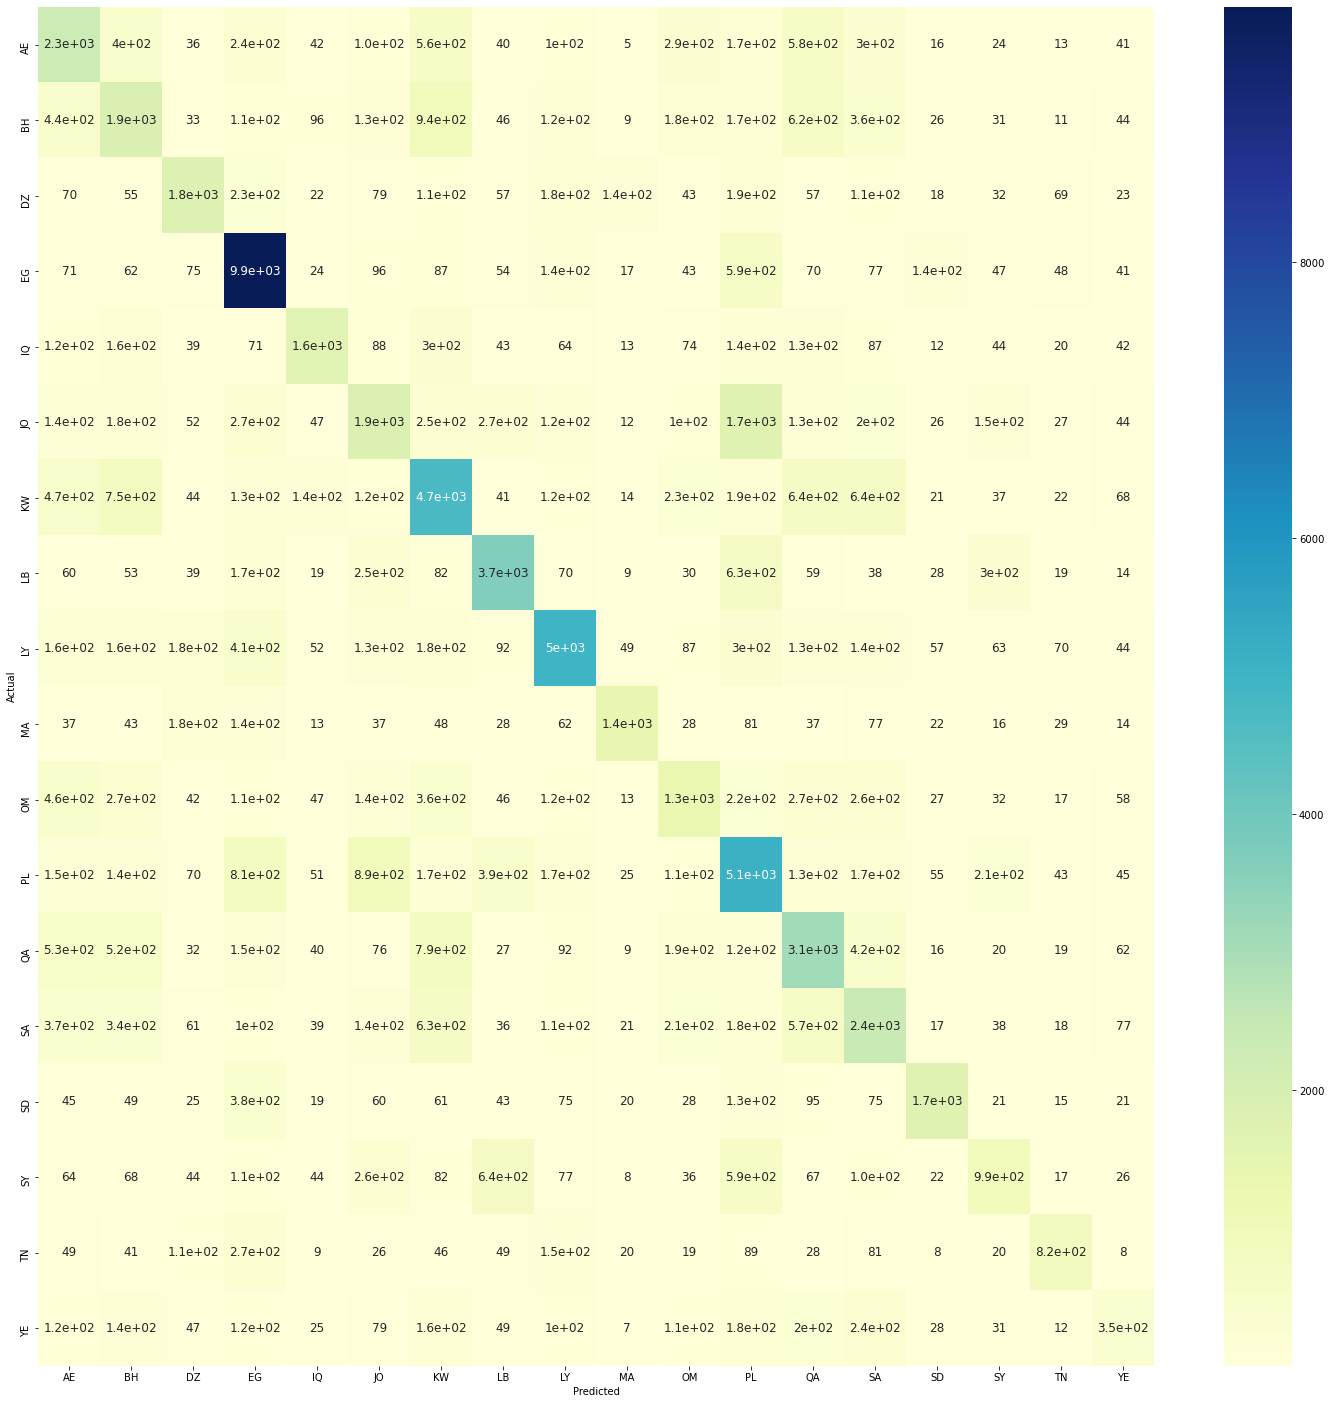

In [67]:
import matplotlib.pyplot as plt
y_pred_nv = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_nv)
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (25,25))
seaborn.heatmap(df_cm,cmap= "YlGnBu", annot=True,annot_kws={"size": 12})
plt.savefig("bayes confusion")

Insights

results show that the model succeeded to predict egyptian dialect better than other dialects

Saving the Model

In [80]:
import pickle

pickle.dump(clf, open('MultinomialNB.pkl','wb'))# saving
 

# LSTM  Model

initializing the AraVec Skip-gram word embedding

getting Data transformed into matrix                                                                                      
each row represent a sentence and each column represent a word                                                                                                                                                                               the cell value should indicate whether such a word exists in the sentence or not,
this matrix is saved in padded_docs

In [85]:
columns=["dialect_AE","dialect_BH","dialect_DZ","dialect_EG","dialect_IQ","dialect_JO","dialect_KW","dialect_LB","dialect_LY","dialect_MA","dialect_OM","dialect_PL","dialect_QA","dialect_SA","dialect_SD","dialect_SY","dialect_TN", "dialect_YE"]

In [33]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec

# prepare tokenizer
t = Tokenizer()
X=df['fineText'] 
y=df[["dialect_AE","dialect_BH","dialect_DZ","dialect_EG","dialect_IQ","dialect_JO","dialect_KW","dialect_LB","dialect_LY","dialect_MA","dialect_OM","dialect_PL","dialect_QA","dialect_SA","dialect_SD","dialect_SY","dialect_TN", "dialect_YE"]] 

 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0, stratify = y)
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1


# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train)
# pad documents to a max length of a tweet
tweets=df['fineText'].tolist()
maxstring=max(tweets, key=len)
max_length=len(maxstring.split(' '))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, 
padding='post')
 
 

in The following cell the library Arabic word to vector is loaded from Memory
to be used as 

In [35]:
# load the whole embedding into memory
w2v_embeddings_index={}
TOTAL_EMBEDDING_DIM=300
embeddings_file='full_grams_sg_300_twitter/full_grams_sg_300_twitter.mdl'
w2v_model =KeyedVectors.load(embeddings_file)
for word in w2v_model.wv.vocab:
    w2v_embeddings_index[word] = w2v_model[word]
print('Loaded %s word vectors.', len(w2v_embeddings_index))# load the whole embedding into memory
 

<ipython-input-35-f08b62b917b8>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_embeddings_index[word] = w2v_model[word]


Loaded %s word vectors. 1476715


Then, creating an embedding matrix for words in the training dataset.

In [36]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))
for word, i in t.word_index.items():
    embedding_vector = w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Embedding Matrix shape:', embedding_matrix.shape) # vocab size * 300 hundred features

Embedding Matrix shape: (424251, 300)


Embidding Layer

In [37]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, TOTAL_EMBEDDING_DIM, 
                                            weights=[embedding_matrix], 
                                            input_length=max_length, trainable=False)
input_placeholder= tf.keras.Input(shape=(max_length,), dtype='int32')
input_embedding = embedding_layer(input_placeholder)


In [53]:
num_classes=y.shape[1]
labels=y_train.to_numpy()


In [49]:
# adding LstM layer
lstm= tf.keras.layers.LSTM(units=100, activation='relu')(input_embedding)
 
preds = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'activation')(lstm)
model = tf.keras.models.Model(inputs=input_placeholder, outputs=preds)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['categorical_accuracy'])
 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 embedding (Embedding)       (None, 57, 300)           127275300 
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 activation (Dense)          (None, 18)                1818      
                                                                 
Total params: 127,437,518
Trainable params: 162,218
Non-trainable params: 127,275,300
_________________________________________________________________


In [55]:
#Training the Model
history= model.fit(padded_docs.tolist(), labels.tolist(), epochs=1, verbose=0)

The Model

In [69]:
loss, accuracy = model.evaluate(padded_docs.tolist(), labels.tolist(), verbose=0)
print('Accuracy:',accuracy*100)
max_item = max(my_list)
print(f'Max index is : {my_list.index(max_item)}'

Accuracy: 6.7847564816474915


In [106]:
#testing on simple text
text=["عمل جيد"]
encoded_text = t.texts_to_sequences(text)
print('encoded_text',encoded_text) 
padded_text = pad_sequences(encoded_text, maxlen=max_length, padding="post")
print("padded_text:",padded_text)
result=model.predict(padded_text)[0].tolist()
max_item = max(result)
predicted=columns[result.index(max_item)]
print(' Input %s \n Prediction Matrix: ', (text,result))
print(' Input %s \n Prediction: ', (text,predicted))
print(max_item)
 

encoded_text [[415, 2698]]
padded_text: [[ 415 2698    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]
 Input %s 
 Prediction Matrix:  (['عمل جيد'], [6.913288962095976e-05, 1.20207951113116e-05, 3.6103968703571354e-09, 5.909731407882646e-05, 0.00036005309084430337, 0.017405003309249878, 0.0008440765086561441, 0.01324489340186119, 1.9770519429584965e-05, 9.37900035413719e-11, 4.088814966962673e-05, 0.0019246548181399703, 0.9636030793190002, 1.7797522104956442e-06, 0.001849577878601849, 0.0005660380120389163, 3.3126503762304083e-09, 5.355705462450899e-12])
 Input %s 
 Prediction:  (['عمل جيد'], 'dialect_QA')
0.9636030793190002


Another model that could be used 

In [54]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout
labels=y_train.tolist()
y=pd.DataFrame(y_train)
num_classes=len(y['transformed'].unique())

model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, TOTAL_EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_length,trainable=False))  
model.add(Dense(1024, input_shape=(max_length,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['categorical_accuracy'])
 


In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 57, 300)           127275300 
                                                                 
 dense_1 (Dense)             (None, 57, 1024)          308224    
                                                                 
 activation_1 (Activation)   (None, 57, 1024)          0         
                                                                 
 dropout (Dropout)           (None, 57, 1024)          0         
                                                                 
 dense_2 (Dense)             (None, 57, 18)            18450     
                                                                 
 activation_2 (Activation)   (None, 57, 18)            0         
                                                                 
Total params: 127,601,974
Trainable params: 326,674
No

Another model that we could Build 

In [24]:

def build_model(vocab_size, TOTAL_EMBEDDING_DIM,num_classes, batch_size = 64):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, TOTAL_EMBEDDING_DIM, 
                                            weights=[embedding_matrix], 
                                            input_length=max_length, 
                                            batch_input_shape=[batch_size, None],
                                            trainable=False),
    tf.keras.layers.LSTM(units=1024,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size),
    tf.keras.layers.Dense(1024, input_shape=(max_length,)),
    tf.keras.layers.Dense(num_classes),
      
  ])
  return model
num_classes=len(df['dialect'].unique())
model = build_model(vocab_size,TOTAL_EMBEDDING_DIM,num_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (64, None, 300)           111970800 
                                                                 
 lstm_2 (LSTM)               (64, None, 1024)          5427200   
                                                                 
 dense_2 (Dense)             (64, None, 373236)        382566900 
                                                                 
 dense_3 (Dense)             (64, None, 1024)          382194688 
                                                                 
 dense_4 (Dense)             (64, None, 18)            18450     
                                                                 
Total params: 882,178,038
Trainable params: 770,207,238
Non-trainable params: 111,970,800
_________________________________________________________________
